# Libraries

In [28]:
import numpy as np
import pandas as pd
import seaborn as sns
import pickle

import nltk

import string

import re, warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

import matplotlib.ticker as ticker
import matplotlib.ticker as mtick

from collections import defaultdict  # For word frequency
from collections import Counter
from itertools import chain
from nltk.util import ngrams
from nltk import word_tokenize
from textblob import TextBlob


# spacy for lemmatization
import spacy
nlp = spacy.load('en_core_web_lg')

from gensim.models.phrases import Phrases, Phraser


import matplotlib.pyplot as plt
from wordcloud import WordCloud


%matplotlib inline

pd.set_option("max_rows", None)
pd.set_option('display.width', None)
pd.set_option('max_columns', None)
pd.set_option('max_colwidth', None)

In [29]:
df_data = pd.read_excel('./data/tbl_Reviews-4-302.xlsx', sheet_name='ForExport')
df_data = df_data.dropna(subset=['reviewBody'])

df_reviews = df_data[['BrandForm','reviewTitles', 'reviewBody1', 'Rating','Product', 'Source','postdate', 'Class']]
df_reviews = df_reviews.rename(columns={"reviewBody1": "Text"})

# Functions

In [30]:
def plotReviews(df_BrandFormCountTotals):
    """This function creates the grph of the reviews, takes in a dataframe"""
    fig, ax = plt.subplots(1, 1, figsize=(15, 3))

    ax = sns.barplot(x="BrandForm", y="BF_Cnt", data=df_BrandFormCountTotals);
    for p in ax.patches:
        #print(p.get_height())
        percentage = '{:.0f}'.format(p.get_height())

        x = p.get_x() + p.get_width() - .2
        y = p.get_y() + p.get_height() 
        ax.annotate(percentage, (x, y), size=20, weight='bold',ha='right');

        plt.xticks(fontsize =18)
        plt.yticks(fontsize =15)
        plt.fontsize =(35)
        plt.title('Reviews By Brand',fontsize =30)
        ax.axes.xaxis.set_visible(True)
        ax.set_ylabel("Count", size=15)
        plt.xlabel (None)
    #     fig.subplots_adjust(top=.25)
    #plt.tight_layout();
    fig.subplots_adjust(top=2)
    plt.show();
    ax.grid(False)

def reviewSentimentByBrand_MutliClass():
    """ This function generates a graph showing reviws by positive, negative, nuetral"""
    fig, ax = plt.subplots(1, 1, figsize=(15, 2))
    df_reviews_ByBrand_sorted = df_reviews_ByBrand.sort_values(by=['Order'])
    ax = sns.barplot(x="BrandForm", y="Sent_Freq", hue="Sent", data=df_reviews_ByBrand_sorted, palette=['#C00000','#CC8963','#5F9E6E']);
    
#     total = df_SentByBrand['Count'].sum()
    for p in ax.patches:
#         print(p.get_height())
        percentage = '{:.0f}%'.format(100 * p.get_height())
        
#         print(percentage)
        x = p.get_x() + p.get_width() - .2
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y), size=20, weight='bold');
    
    plt.xticks(fontsize =18)
    plt.yticks(fontsize =15)
    plt.fontsize =(35)
    plt.title('Sentiments By Brand',fontsize =30)
    ax.axes.xaxis.set_visible(True)
    ax.set_ylabel("% of Sentiments", size=15)

    plt.setp(ax.get_legend().get_texts(), fontsize='22') # for legend text
    plt.setp(ax.get_legend().get_title(), fontsize='0') # for legend title
    plt.legend(loc='upper left')
    plt.xlabel (None)
    ax.grid(False)
    fig.subplots_adjust(top=3)

    plt.show();
    


def removelowfrequenceywords(doc_clean_tokenized, i):
    """ This function removes low frequency words, takes in a column and a number that words must be greater than"""
    frequency = defaultdict(int)
    for text in doc_clean_tokenized:
        for token in text:
            frequency[token] += 1
    # Only keep words that appear more than ? insert
    doc_clean_tokenized = [[token for token in text if frequency[token] > i] for text in doc_clean_tokenized]
    
    return doc_clean_tokenized

def createLDAFromTFIDF(corpus_tfidf, NumbOfTopics):
    """ This function stores the created models into a dataframe for future access"""
    lda_model_tfidf = LdaMulticore(corpus_tfidf, num_topics=NumbOfTopics, 
                                   id2word=corpus_dictionary,minimum_probability=.2, random_state=100,
                                  #update_every=1,
                                   chunksize=100,passes=10,alpha='asymmetric',per_word_topics=True, 
                                   #n_jobs = -1
                                  )
    return lda_model_tfidf

def createWordCloud(model):
    """ This function creates a word cloud of the words associated with each topic"""
    #create wordclouds for hld https://towardsdatascience.com/dont-be-afraid-of-nonparametric-topic-models-part-2-python-e5666db347a
    for t in range(model.num_topics):
        plt.figure()
        plt.imshow(WordCloud().fit_words(dict(model.show_topic(t, 10))))
        plt.axis("off")
        plt.title("Topic #" + str(t))
        plt.show()

def evaluateCoherenceLDA(ldaModelToEvaluate):
    """ This function generates a coherence score for each LDA model"""
    #https://stackoverflow.com/questions/54762690/coherence-score-0-4-is-good-or-bad
    coherencemodel = CoherenceModel(model=ldaModelToEvaluate, texts=doc_clean_tokenized_Lem, dictionary=corpus_dictionary, coherence='c_v')
    Coherence = coherencemodel.get_coherence()
    return Coherence

def get_top_topic_per_review(ldamodel, corpus, texts):
    '''ldamodel = the current model, corpus = doc_term_matrix, text = ls_of_textToUse'''
    # Match reviews to dominate Topics
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[doc_term_matrix]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

def removewordswithcertainCount2(df, count):
    """Removes words that do not have a specified count in the corpus"""
    # split words into lists
    v = df.str.split().tolist() # [s.split() for s in df['Col2'].tolist()]
    # compute global word frequency
    c = Counter(chain.from_iterable(v))
    # filter, join, and re-assign
    df = [' '.join([j for j in i if c[j] > count]) for i in v]
    df = df
    return df


### Contractions Used from Replacement

In [31]:
# di = {"searchingfor":"changeto"}
contraction_dict = {"w/out":"with out","gonna":"going to",
                    
                    "didnt":"did_not", "didn't": "did_not",
                    "dont":"do_not","do not":"do_not",
                    "Don’t":"do_not",
                    
                    "Gotta": "have to",
                    "ain't": "is_not", "aren't": "are_not",
                    
                    "can't": "can_not", 
                    "cant": "can_not", 
                    "can not": "can_not", 
                    
                    "could've": "could have", " cause ": " because ",
                    "couldn't": "could_not",  
                    "doesn't": "does_not", "don't": "do_not", 
                    
                    "hadn't": "had_not", "hasn't": "has_not", "havent": "have_not",
                    "hadn’t": "had_not",
                    
                    "haven't": "have_not", "he'd": "he would","he'll": 
                    "he will", "he's": "he is", "how'd": "how did", 
                    "how'd'y": "how do you", "how'll": "how will", 
                    "how's": "how is",  "i'd": "i would", "i'd've": 
                    "i would have", "i'll": "i will", "i'll've": 
                    "i will have","i'm": "i am", "i've": 
                    "i have", "i'd": "i would", "i'd've": 
                    "i would have", 
                    "i'll": "i will",  " ill ":" i will ",
                    
                    "i'll've": "i will have","I’ve":"i have",
                    
                    "i'm": "i am", "i've": "i have", 
                    " i’m": "i am",
                    
                    "isn't": "is_not", "isn’t":"is_not",
                    
                    
                    "it'd": "it would", "it'd've": 
                    "it would have", "it'll": "it will", "it'll've": 
                    "it will have","it's": "it is", "let's": "let us", 
                    "ma'am": "madam", "mayn't": "may not", "might've": 
                    "might have","mightn't": "might not","mightn't've": 
                    "might_not_have", "must've": "must_have", "mustn't": 
                    "must_not", "mustn't've": "must not have", "needn't": 
                    "need not", "needn't've": "need not have","o'clock": 
                    "of the clock", "oughtn't": "ought_not", "oughtn't've": 
                    "ought not have", "shan't": "shall_not", "sha'n't": 
                    "shall not", "shan't've": "shall_not have", "she'd": 
                    "she would", "she'd've": "she would have", "she'll": 
                    "she will", "she'll've": "she will have", "she's": 
                    "she is", "should've": "should have", "shouldn't": 
                    "should_not", "shouldn't've": "should_not have", "so've": 
                    "so have","so's": "so as", "this's": "this is","that'd": 
                    "that would", "that'd've": "that would have", "that's": 
                    "that is", "there'd": "there would", "there'd've": "there would have", 
                    "there's": "there is", "here's": "here is","they'd": "they would", 
                    "they'd've": "they would have", "they'll": "they will", "they'll've": 
                    "they will have", 
                    
                    "they're": "they are", "they’re":"they are", "they've": "they have", "to've":
                    "to have", "wasn't": "was_not", "wasn’t":"was_not",
                    
                    
                    "we'd": "we would",
                    "we'd've": "we would have", "we'll": "we will", "we'll've": 
                    "we will have", "we're": "we are", "we've": "we have",
                    "werent":"were_not",
                    "weren't": "were_not", 
                    
                    "what'll": "what will",
                    "what'll've": "what will have", "what're": "what are",  
                    "what's": "what is", "what've": "what have", 
                    "when's": "when is", "when've": "when have", 
                    "where'd": "where did", "where's": "where is",
                    "where've": "where have", "who'll": "who will",
                    "who'll've": "who will have", "who's": "who is",
                    "who've": "who have", "why's": "why is", "why've": 
                    "why have", "will've": "will have", "won't": 
                    "will_not",  "wont": "will_not",
                    
                    "won't've": "will_not have", 
                    
                    "would've":"would have",  "wouldve": "would have", 
                    
                    "wouldn't": "would_not","wouldn’t":"would_not", 'wouldnt': "would_not",
                    "would’ve":'would have', 
                    
                    
                    "wouldn't've": "would_not have", "y'all": "you all", "y'all'd": 
                    "you all would","y'all'd've": "you all would have","y'all're":
                    "you all are","y'all've": "you all have","you'd": "you would", 
                    "you'd've": "you would have", "you'll": "you will", "you'll've": 
                    "you will have", "you're": "you are", "you've": "you have",
                    " im ": " i am ", '1st':'first'
                   }

### Clean Text Functions

In [32]:
def tolower(text):
    """Lower texts"""
    tolower = ' '.join([i.lower() for i in text.split()])
    return tolower

def replaceappostrophe(x):
    """Replaces words in corpus based on enclosed dictionary"""
    dic = {"’":"'"}
    for word in dic.keys():
        x = x.replace(word, dic[word])
    return x

def clean(text):
    """Cleans texts"""
    text = re.sub('[?!.,"#$%\'()*+-/:;<=>@[\\]^`{|}~]', ' ', text) # Removing
    text = re.sub(r'[^A-Za-z0-9 ]+', '', text) # just added
    text = re.sub(r'(�ïª7¼‹ãå9ó8òêìâáçI©è¢äüî¡¾ë£ùðš0„«»ôöœ´žàµ•¬ý¤"“¥é€±,)', ' ', text) # just added\
#     textArr= text.split()
#     text = ' '.join([w for w in textArr if ( not w.isdigit() and  ( not w.isdigit() and len(w)>3))]) 
    return text


def correct_words(x):
    """Replaces words in corpus based on enclosed dictionary"""
    dic = {'doesnt':'does not','instagram': 'social medium','whatsapp': 'social medium','snapchat': 'social medium',
          'ipad2s':'ipad2', 'abt': 'about' , '1st': 'first'}
    for word in dic.keys():
        x = x.replace(word, dic[word])
    return x




def clean_numbers(x):
    """Removes Numbers from tweets"""
    x = re.sub('[0-9]', '', x)
#     x = re.sub('[0-9]{4}', '', x)
#     x = re.sub('[0-9]{3}', '', x)
#     x = re.sub('[0-9]{2}', '', x)
    return x

def replace_words(d, col):
    """Replaces words in corpus based on passed in dictionary"""
    d1={r'(?<!\S)'+ k.strip() + r'(?!\S)':k1 for k1, v1 in d.items() for k in v1.split(',')}
    df_reviews[col] = df_reviews[col].replace(d1, regex=True)
    return df_reviews[col]



def getSubjectivity(text):
    """This function calculates the subjectivey of a tweet"""
    return TextBlob(text).sentiment.subjectivity

# Create a function to get the polarity
def getPolarity(text):
    """This function calculates the polarity of a tweet"""
    return  TextBlob(text).sentiment.polarity

def lemmatization(texts):
    """Performs lemmatization"""
    texts_out = []
    doc = nlp(texts)
    #using spacey to lemmatize
    texts_out.append([token.lemma_ for token in doc])
    listToStr = ' '.join([str(elem) for elem in texts_out[0]])
    return listToStr

# Preprocessing

In [33]:
df_reviews["TextClean"] = df_reviews['Text']

df_reviews["TextClean"] = df_reviews["TextClean"].apply(tolower)
df_reviews["TextClean"].replace(contraction_dict, inplace=True, regex=True)
df_reviews["TextClean"] = df_reviews["TextClean"].apply(replaceappostrophe)
df_reviews["TextClean"] = df_reviews["TextClean"].apply(clean)
df_reviews["TextClean"] = df_reviews["TextClean"].apply(clean_numbers)
df_reviews["Sent"] = df_reviews["Rating"].apply(lambda x: 'Pos' if x>=4 else 'Neg' if x<=2 else 'Neut')
# df_reviews["Class"] = df_reviews["Rating"].apply(lambda x: 1 if x>=4 else 0)


# #Create two new columns : 'Subjectivity' & 'Polarity'
df_reviews['Subjectivity'] = df_reviews['TextClean'].apply(getSubjectivity)
df_reviews['Polarity'] = df_reviews['TextClean'].apply(getPolarity)

## Sentiment Summary

In [34]:
df_BrandFormCountTotals = df_reviews['BrandForm'].value_counts()
df_BrandFormCountTotals = df_BrandFormCountTotals.reset_index()
df_BrandFormCountTotals.columns=["BrandForm","BF_Cnt"]

df_BrandFormCountTotals1 = df_reviews['BrandForm'].value_counts(normalize=True)
df_BrandFormCountTotals1 = df_BrandFormCountTotals1.reset_index()
df_BrandFormCountTotals1.columns=["BrandForm","BF_Freq"]


df_BrandFormCountTotals
df_reviews = df_reviews.merge(df_BrandFormCountTotals, on='BrandForm')
df_reviews = df_reviews.merge(df_BrandFormCountTotals1, on='BrandForm')
#df_reviews.head(1)

In [35]:
data = {'BrandForm': ['ImpossiblePatty','IncogmeatoPatty','ImpossibleBrick','BeyondBrick','BeyondPatty'],
        'Order': [1,2,3,4,5]
        }

df_order = pd.DataFrame(data, columns = ['BrandForm', 'Order'])

In [36]:
df_reviews_ByBrand = df_reviews[["BrandForm","Sent", 'BF_Cnt']].groupby(['BrandForm', 'Sent', 'BF_Cnt'])[['Sent']].count()
df_reviews_ByBrand = df_reviews_ByBrand.stack().reset_index()
df_reviews_ByBrand.drop(columns=["level_3"], inplace=True)
df_reviews_ByBrand.columns=["BrandForm","Sent","BF_Cnt", "Sent_Cnt"]
df_reviews_ByBrand['Sent_Freq'] = df_reviews_ByBrand['Sent_Cnt']/df_reviews_ByBrand['BF_Cnt']
df_reviews_ByBrand = df_reviews_ByBrand.merge(df_order, on='BrandForm')
# df_reviews_ByBrand

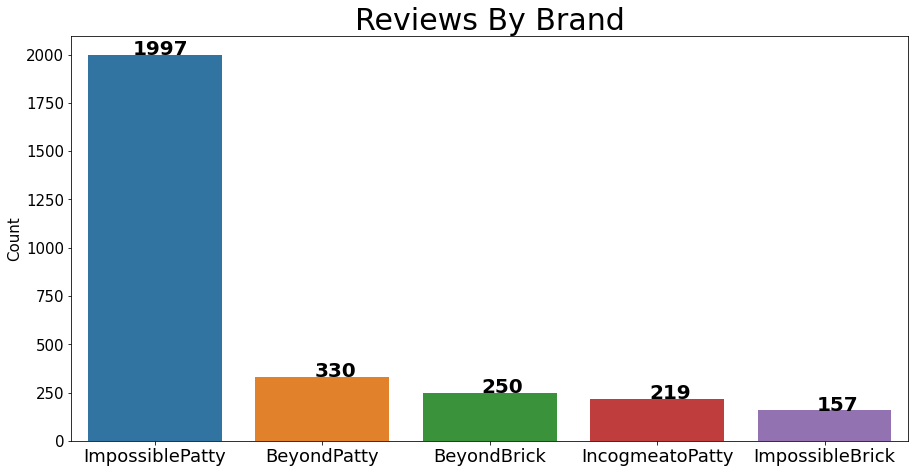

In [37]:
plotReviews(df_BrandFormCountTotals)

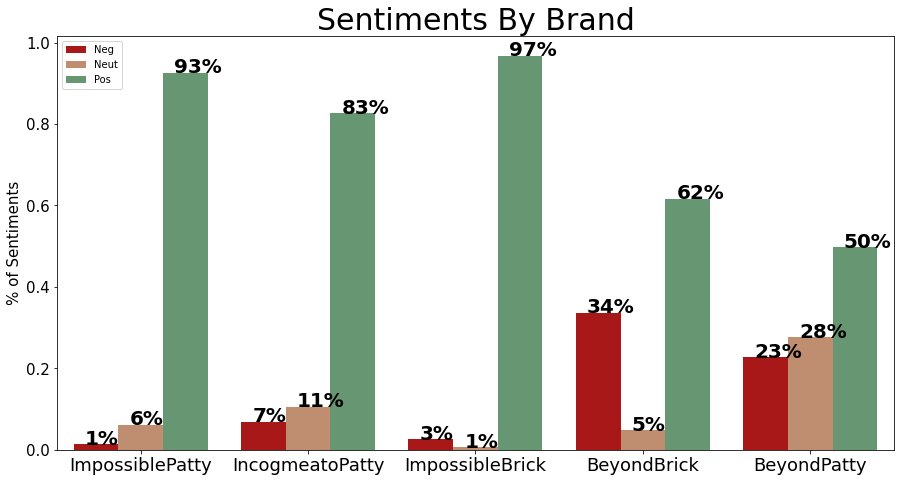

In [38]:
reviewSentimentByBrand_MutliClass()

## Initial Word Count Analysis

In [39]:
# Get Stats on corpus
entire_corpus = " ".join(df_reviews["TextClean"])
numberOfwords = len(entire_corpus)
print(f'Number of words in corpus: {numberOfwords}')

unique_words = set(word_tokenize(entire_corpus))
numberOfUniqueWords = len(unique_words)
print(f'Number of unique words in corpus: {numberOfUniqueWords}')


# creates a dictionary so you can get count by word ex. {'3': 149,'g': 55,'i
counter = Counter(word_tokenize(entire_corpus))
df_From_Dict_MostCommonwords =  pd.DataFrame(counter.most_common(),columns=['words', 'count'])
df_From_Dict_MostCommonwords_sorted = df_From_Dict_MostCommonwords.sort_values(by='count', ascending=False)

Number of words in corpus: 627286
Number of unique words in corpus: 4433


# Initial Bigram - Trigram Creation

In [40]:
# df_reviews["TextClean2"] = df_reviews["TextClean1"]
df_reviews["TextClean2"] = df_reviews["TextClean"]
# di = {"searchingfor":"changeto"}

di = {"burgers":"burger", "goodd":"good", " eco ":" environment ",
     " ok ":" okay ", " son ":" family ", " prep ": " preparation ",
     " oz ":" ounce ", 
      " sub ": " substitute "," substituted ": " substitute ",
     " substitutes ": " substitute ", " substitution ": " substitute " ,
     " seasoned ": " seasoning ", " seasonings ": " seasoning ", 
      " seasons ": " seasoning " , " fav ": " favorite ", " expectations ":" expectation ",
      " expected ": " expectation ", " expecting " : " expectation ", 
      " expects ": " expectation ", " replace ": " substitute ","imitation": "fake", 
      " switching ": " changing " , 
      " anit ": " against ", " sear ": " cook " , " imitate ":" fake ", 
      " dog ": " pet ", " doggie ": " pet ", " dogs ": " pet ",
      " cat ": " pet ", " cats ": " pet ", " lb ": " pound ", " kid ": " family ",
      "kidding": "joke", " def ": " definitely ", "garlic powder":"seasonings", 
      "onion poweder":"seasonings","worcestershire":'seasonings', 'pickle':'toppings',
      'mayonnaise':'toppings', 'smells': 'smell', 'trash':'garbage', 'gross':'bad', 
      ' george foreman ':' cook ', 'mimic':'similar'
     }

df_reviews["TextClean2"].replace(di, inplace=True, regex=True)



df_keywordDict = pd.read_excel("./data/qry_Export_KeyWordDict.xlsx")
dct  = dict(zip(df_keywordDict.searchfor, df_keywordDict.changeTo))
df_reviews["TextClean2"].replace(dct, inplace=True, regex=True)

In [41]:
di = {"substitutes":"substitute", "meatballss" :"meatballs",  "toppingss":"toppings", 
      "inexpensiveer":"inexpensive", "thankfuls":"thankful" , "goodly" : "good",
      " info ": " information "
     }
df_reviews["TextClean2"].replace(di, inplace=True, regex=True)

In [42]:
entire_corpus = " ".join(df_reviews["TextClean2"])
numberOfwords = len(entire_corpus)
print(f'Number of words in corpus: {numberOfwords}')

unique_words = set(word_tokenize(entire_corpus))
numberOfUniqueWords = len(unique_words)
print(f'Number of unique words in corpus: {numberOfUniqueWords}')


# creates a dictionary so you can get count by word ex. {'3': 149,'g': 55,'i
counter = Counter(word_tokenize(entire_corpus))
df_From_Dict_MostCommonwords =  pd.DataFrame(counter.most_common(),columns=['words', 'count'])
df_From_Dict_MostCommonwords_sorted = df_From_Dict_MostCommonwords.sort_values(by='count', ascending=False)
df_From_Dict_MostCommonwords_sorted

Number of words in corpus: 614437
Number of unique words in corpus: 3937


,words,count
0,i,5270
1,the,4018
2,and,3430
3,burger,3257
4,it,3207
5,good,3158
6,a,2920
7,to,2616
8,is,1976
9,taste,1892


## Iteration 2 - Bigram/ Trigram Analysis

In [43]:

di = {'impossible burger':'impossible_burger', 'burger burgers':'burger', 'burger burger':'burger',
      'made from plants':'made_from_plants', 'made from':'made_from',
     'taste like':'taste_like', 'tasted like':'taste_like',
      'taste good':'taste_good',  'tastes like':'taste_like','morning star':'morningstar',
      'taste bad':'taste_bad', 'smell like':'smell_like','smell bad':'smell_bad',
      'look like':'look_like','looks like':'look_like', 'looks bad':'look_bad',
      ''
      ' on par ':' similar ', 'onpar':'similar','thrilled':'excited',
      
      'feel like': 'feel_like','feels like': 'feel_like','cannot stand': 'bad',
      
      'plant based':'plant_based', 'good good':'good', 'real meat':'red_meat',
    'impossible_burger made_from_plants':'impossible_burger_made_from_plants',
   
      
      'bad taste':'taste_bad', 'veggie burger':'veggie_burger', 
     'red meat': 'red_meat', 'ground beef':'red_meat', 'beyond meat':'beyond_meat', 'beyond burger':'beyond meat',
     'regular burger':'red_meat', 'real beef':'red_meat', 'real thing':'red meat', 'good good':'good',
      ' burgers ':' burger ', 'goodd':'good', 'buying':'purchase',' buy ':' purchase ','chipotle':'seasonings',
      'ideal':'good', 'foreman':'cook', 'charred':'cook', 'omg':'good', 'after taste':'aftertaste', 'steep':'expensive',
      'downside':'bad', 'taste buds':'taste_buds',  'sloppy joe':'sloppy_joe', 'game changer':'good', 
      'fall apart':'fall_apart','waste':'expensive','alright':'okay', 'exact':'similar', 'no idea':'no_idea',
      'any idea':'no_idea', 'decent':'okay', 'bright red':'bright_red', 'goodrs': 'good', 'funny smell': 'bad smell',
      'after tase':'after taste', 'smell funny':'bad smell', 'convenience':'convenient', 'dry ice':'dryice', 
      ' yum ':' good ','unsure':'scared', 'red_meat':'beef', 'vegans':'vegan','aroma':'smell','at least':'at_least',
      'ground chuck':'ground_beef', 'grocery store':'grocery_store', ' hate ': ' bad ', 'nonmeat':'vegetarian',
      'outstanding':'good', ' crap ':' bad ', 'glad':'happy', 'poop':'bad', ' crisp ':' crispy ', ' mush ':' bad ',
      'meatless monday':  'meatless_monday', 'thank you':'thank_you', 'normal burger':'beef_burger',' fine ': ' okay ',
      'meat lover':'meat_lover', 'beef lover':'meat_lover', 'crumbled apart':'crumble_apart',
      'fallin apart':'crumble_apart','falling apart':'crumble_apart',
      'broken apart':'crumble_apart', 'fall apart':'crumble_apart',' love ': ' good ', 'ground meat':'ground_beef',
      'consume':'eat', 'black bean':'black_bean', 'phenomenal':'good', 
      'mouth feel':'mouth_feel', 'stay away':'stay_away', 'no guilt':'guilt_free', 'guilt free':'guilt_free'

      
     
     }

df_reviews["TextClean2"].replace(di, inplace=True, regex=True)

In [44]:
di = {'impossible_burger made_from_plants':'impossible_burger_made_from_plants',
     'burger made_from_plants':'burger_made_from_plants'}

df_reviews["TextClean2"].replace(di, inplace=True, regex=True)

In [45]:
one_Giant_Corpus_From_DF = " ".join(df_reviews["TextClean2"])

token = nltk.word_tokenize(one_Giant_Corpus_From_DF)
# bigrams = ngrams(token,2)
# trigrams = ngrams(token,3)
# fourgrams = ngrams(token,4)
# fivegrams = ngrams(token,5)
# print(Counter(bigrams))
brigramcounts = pd.Series(ngrams(token,2)).value_counts()
# brigramcounts.reset_index()

In [46]:
brigramcounts = brigramcounts.to_frame()
brigramcounts.reset_index(inplace=True)
brigramcounts.columns =["words","count"]
di = {i[0] + ' ' + i[1] : i[0] + '_' + i[1] for i in brigramcounts['words']}
df_di = pd.DataFrame(di.items(), columns=['searchFor', 'changeto'])

framesToconcatenate = [df_di, brigramcounts]
df_bygramsToreview = pd.concat(framesToconcatenate, ignore_index=True, axis=1)
df_bygramsToreview.columns=['searchFor', 'changeto', 'set', 'count']
# s_di = pd.Series(di)
# # new_d = pd.Series(d)
# df_bygramsToreview['dictionary'] = s_di
df_bygramsToreview['dictionary'] = pd.Series(di).values

# df_bygramsToreview.to_excel("df_bygramsToreview.xlsx")

In [47]:
# df_bygramsToreview

In [48]:
entire_corpus1 = " ".join(df_reviews["TextClean2"])
numberOfwords = len(entire_corpus)
print(f'Number of words in corpus: {numberOfwords}')

unique_words = set(word_tokenize(entire_corpus1))
numberOfUniqueWords = len(unique_words)
print(f'Number of unique words in corpus: {numberOfUniqueWords}')


# creates a dictionary so you can get count by word ex. {'3': 149,'g': 55,'i
counter = Counter(word_tokenize(entire_corpus1))
df_From_Dict_MostCommonwords1 =  pd.DataFrame(counter.most_common(),columns=['words', 'count'])
df_From_Dict_MostCommonwords_sorted1 = df_From_Dict_MostCommonwords1.sort_values(by='count', ascending=False)
df_From_Dict_MostCommonwords_sorted1

Number of words in corpus: 614437
Number of unique words in corpus: 3950


,words,count
0,i,5270
1,the,4018
2,and,3430
3,good,3287
4,it,3207
5,a,2920
6,to,2616
7,burger,2035
8,is,1976
9,meat,1667


### Begin To Remove Irrelevant / Consolidate words

In [49]:
# df_reviews_Find = df_reviews[df_reviews['TextClean4'].str.contains(" definitelyinitely ")][['Text','TextClean4']]
# df_reviews_Find
# df_reviews_Find

In [50]:
def RemoveGarbageWords1(text):
    """Removes Garbage words"""
    listofgarbagewords = [
                          
                          'impossible_burger_made_from_plants','impossible_burger', 'beyond_burger',
                            'plant_based', 'eat', 'beyond_meat',
                          
                          'received_free_sample','coupon_from_pinchme',
                         'person','around','upon' ,'alone', 'follow', 'since',
                         'oh', 'literally', 'willing' ,'bring', 'several', 'eye', 'hear', 'maybe',
                         'couple', 'behind', 'keep', 'probably', 'someone', 'fully', 'honestly', 'anything',
                         'arrive', 'party', 'law', 'brother', 'sister', 'mother', 'man', ' hour ',
                         'bought', 'unless', 'do', 'may', 'due', 'call', 'properly','ha', 'smokey',
                          'edge', 'attention', 'forward', 'mind', 'although', 'yet', 'slap', 'little',
                          'fairly', 'somewhat', 'area','mind', 'ask', 'pretty','always', 'four',
                          'obviously', 'basically', 'sit', 'hours', ' need ', 'needed', 'point', 
                          'got', 'back', 'bonus', 'check', 'bother', 'lately', 'lent', 'pinchme',
                          
                          'i','me','my','myself','we','our','ours','ourselves','you',"you're",
                           "you've","you'll","you'd",'your','yours','yourself','yourselves','he',
                          'him','his','himself','she',"she's",'her','hers','herself','it',"it's",
                          'its','itself','they','them','their','theirs','themselves',
                           'what','which','who','whom','this','that',"that'll",'these','those',
                          'am','is','are','was','were',
                           'be','been','being','has','had','having','do','does','did','doing',
                          'a','an','the','and',
                           'but','if','or','because','as','until','while','of','at','by','for',
                          'about','against','between',
                           'into','through','during','before','after','above','below','to','up',
                          'down','in','out','on',
                           'off','over','under','again','further','then','once','here','there',
                          'when','where','why','how',
                           'all','any','both','each','few','more','most','other','some','such',
                          'nor','not','only','own',
                           'same','so','than','too','very','s','t','will','just','would','with','from', 'this', 'made',
                           'they','that', 'them', 'received_free',

                           'impossible_burger','have', 'could', 'beyond', 'impossible', 'incogmeato', 'now', 'year', 
                          'krogers',
                           'target', 'walmart', 'kroger', 'oz', '4', '4oz', '8oz', 'plant', '2', 
                          'impossible_burgers', 'buy','well',
                           'buger_patties_made_from_plants','also', 'buger_burger_made_from_plants', 
                          'product', 'even', 
                           'say', 'buying', 'purchase',

                           'able', ' can ','get', 'give', 'really', 'two', 'well', 'pan', 
                          'seriously', 'indian', 
                           'today','forever', 

                           'lb', 'flat', 'weekend', 'personal', 'personallly', 'took', 
                          'opportunity', 'whether',
                           'totally','chance', 'star', 'rest', 'mom', 'mean', 'night', 
                          ' can ', 'b', 'hardly',
                           'hey', 'five', 'boyfriend', 's', 'tried', 'try', 'much', 'one',
                          'trying', 'first', 'thought', 'still', 'bit', 'husband', 'ever',
                          'something', 'want', 'go', 'believe', 'sure', 'way', 'never','review','find','&'
                          'new', 'started', 'stars', 'con', 'turned', 'afterwards', 'result', 'carl jr',
                          'wise', 'local', 'otherwise', 'u', 'do', 'take', 'interesting', 'heard', 'called',
                          'currently', 'hopefully', 'certain', 'god', 'certainly', 'anticipated', 'indeed',
                          'partner', 'cup', 'reminiscent', 'hot', 'giving', 'paired', 'sort', 'customer',
                          'going', 'ask', 'initially', 'side', 'careful', 'preferred', 'charbroiled',
                          'competitor', 'update', 'thoughts', 'watch','blow', 'one', 'second', 'stuff', 'darn',
                          'dollar', 'large', 'benefit', 'dollars', 'please', 'take', 'deal', 'goes',
                          'reviews', 'within', 'pick', 'definitely', 'well', 'eat', 'think','offer','pleased',
                          'spend', 'response', 'respond', 'post', 'choose', 'direction', 'blue', 'makes', 'make',
                          'actually', 'know', 'use', 'used', 'many', 'new', 'almost', 'cannot', 'didnot', 'donot',
                          'consider', 'considering','considers','grams', 're', 'direction', 'carl','entirely', 'tummy', 'arrive','remember',
                          'thankful', 'aware', 'boy', 'sadly', 'double', ' things ', 'a_lot', 'content', 'straight',
                          'multiple', 'folk', 'impression', 'insanely', 'swear', 'bits', 'cover', 'portion',
                          'nice', 'slightly','come', ' thing ', 'whatever', 'initial', 'should', 'rather', 'piece',
                          'sugar', 'different', 'cause', 'folks',
        
        
                            'i','me','my','myself','we','our','ours','ourselves','you',"you're",
                           "you've","you'll","you'd",'your','yours','yourself','yourselves','he',
                          'him','his','himself','she',"she's",'her','hers','herself','it',"it's",
                          'its','itself','they','them','their','theirs','themselves',
                           'what','which','who','whom','this','that',"that'll",'these','those',
                          'am','is','are','was','were',
                           'be','been','being','has','had','having','do','does','did','doing',
                          'a','an','the','and',
                           'but','if','or','because','as','until','while','of','at','by','for',
                          'about','against','between',
                           'into','through','during','before','after','above','below','to','up',
                          'down','in','out','on',
                           'off','over','under','again','further','then','once','here','there',
                          'when','where','why','how',
                           'all','any','both','each','few','more','most','other','some','such',
                          'nor','not','only','own',
                           'same','so','than','too','very','s','t','will','just','would','with', 'this',
                           'they','that', 'them', 'received_free','have','ever', 
                            #'real', 'regular',
                            'pleasantly','definitely', 'highly', 'absolutely', 'products','pretty','product',
                            'really', 'very', 'exactly', 'much', 'anywhere', 'aside', 'arrive', 'likely','except',
                            'everything', 'yes', 'matter', 'made_from_plants', 'absolute', 'party','burger','morningstar',
                            'wrapped',
                            'consumer','american', 'load', 'thin', 'butter','avoid', 'whoever',
                            'went', 'anymore','job', 'following', 'iron', 'g', 'lol', 'last', 'near','thaw', 'at_least',
                            'slice', 'grocery_store','burger_made_from_plants','made_from', 
        
                          
                  ]        
    
    listofgarbagewords1 = ' '.join([i for i in text.split() if i not in listofgarbagewords])
    return listofgarbagewords1


df_reviews["TextClean3"] = df_reviews["TextClean2"].apply(RemoveGarbageWords1)

In [51]:
# Get Stats on corpus
entire_corpus1 = " ".join(df_reviews["TextClean3"])


# creates a dictionary so you can get count by word ex. {'3': 149,'g': 55,'i
counter = Counter(word_tokenize(entire_corpus1))
df_From_Dict_MostCommonwords1 =  pd.DataFrame(counter.most_common(),columns=['words', 'count'])
df_From_Dict_MostCommonwords_sorted1 = df_From_Dict_MostCommonwords1.sort_values(by='count', ascending=False)
# df_From_Dict_MostCommonwords_sorted1.tail(100)

## Lementize

In [52]:
df_reviews["TextClean4"] = df_reviews["TextClean3"]
df_reviews["TextClean4"] = removewordswithcertainCount2(df_reviews["TextClean4"], 3)

In [53]:
df_reviews['TextClean4'] = df_reviews['TextClean4'].apply(lemmatization)

In [54]:
# Get Stats on corpus
entire_corpus = " ".join(df_reviews["TextClean4"])
numberOfwords = len(entire_corpus)
print(f'Number of words in corpus: {numberOfwords}')

unique_words = set(word_tokenize(entire_corpus))
numberOfUniqueWords = len(unique_words)
print(f'Number of unique words in corpus: {numberOfUniqueWords}')

Number of words in corpus: 213478
Number of unique words in corpus: 833


In [55]:
# Remove rows that have less than 3 words
df_reviews['count'] = df_reviews['TextClean4'].str.count(' ') + 1
print(f'number of rows prior to deleting rows: {len(df_reviews)}')
      
df_reviews = df_reviews[df_reviews['count']>6]

print(f'number of rows after deleting rows: {len(df_reviews)}')

number of rows prior to deleting rows: 2953
number of rows after deleting rows: 1815


In [56]:
# df_reviews["TextClean3"] = removewordswithcertainCount2(df_reviews["TextClean4"], 3)

In [57]:
# Get Stats on corpus
entire_corpus1 = " ".join(df_reviews["TextClean4"])


# creates a dictionary so you can get count by word ex. {'3': 149,'g': 55,'i
counter = Counter(word_tokenize(entire_corpus1))
df_From_Dict_MostCommonwords1 =  pd.DataFrame(counter.most_common(),columns=['words', 'count'])
df_From_Dict_MostCommonwords_sorted1 = df_From_Dict_MostCommonwords1.sort_values(by='count', ascending=False)
#df_From_Dict_MostCommonwords_sorted1.tail(100)

In [58]:
def RemoveGarbageWords1(text):
    """Removes Garbage words"""
    listofgarbagewords = [
                          
                          'impossible_burger_made_from_plants','impossible_burger', 'beyond_burger',
                            'plant_based', 'eat', 'beyond_meat',
                          
                          'received_free_sample','coupon_from_pinchme',
                         'person','around','upon' ,'alone', 'follow', 'since',
                         'oh', 'literally', 'willing' ,'bring', 'several', 'eye', 'hear', 'maybe',
                         'couple', 'behind', 'keep', 'probably', 'someone', 'fully', 'honestly', 'anything',
                         'arrive', 'party', 'law', 'brother', 'sister', 'mother', 'man', ' hour ',
                         'bought', 'unless', 'do', 'may', 'due', 'call', 'properly','ha', 'smokey',
                          'edge', 'attention', 'forward', 'mind', 'although', 'yet', 'slap', 'little',
                          'fairly', 'somewhat', 'area','mind', 'ask', 'pretty','always', 'four',
                          'obviously', 'basically', 'sit', 'hours', ' need ', 'needed', 'point', 
                          'got', 'back', 'bonus', 'check', 'bother', 'lately', 'lent', 'pinchme',
                          
                          'i','me','my','myself','we','our','ours','ourselves','you',"you're",
                           "you've","you'll","you'd",'your','yours','yourself','yourselves','he',
                          'him','his','himself','she',"she's",'her','hers','herself','it',"it's",
                          'its','itself','they','them','their','theirs','themselves',
                           'what','which','who','whom','this','that',"that'll",'these','those',
                          'am','is','are','was','were',
                           'be','been','being','has','had','having','do','does','did','doing',
                          'a','an','the','and',
                           'but','if','or','because','as','until','while','of','at','by','for',
                          'about','against','between',
                           'into','through','during','before','after','above','below','to','up',
                          'down','in','out','on',
                           'off','over','under','again','further','then','once','here','there',
                          'when','where','why','how',
                           'all','any','both','each','few','more','most','other','some','such',
                          'nor','not','only','own',
                           'same','so','than','too','very','s','t','will','just','would','with','from', 'this', 'made',
                           'they','that', 'them', 'received_free',

                           'impossible_burger','have', 'could', 'beyond', 'impossible', 'incogmeato', 'now', 'year', 
                          'krogers',
                           'target', 'walmart', 'kroger', 'oz', '4', '4oz', '8oz', 'plant', '2', 
                          'impossible_burgers', 'buy','well',
                           'buger_patties_made_from_plants','also', 'buger_burger_made_from_plants', 
                          'product', 'even', 
                           'say', 'buying', 'purchase',

                           'able', ' can ','get', 'give', 'really', 'two', 'well', 'pan', 
                          'seriously', 'indian', 
                           'today','forever', 

                           'lb', 'flat', 'weekend', 'personal', 'personallly', 'took', 
                          'opportunity', 'whether',
                           'totally','chance', 'star', 'rest', 'mom', 'mean', 'night', 
                          ' can ', 'b', 'hardly',
                           'hey', 'five', 'boyfriend', 's', 'tried', 'try', 'much', 'one',
                          'trying', 'first', 'thought', 'still', 'bit', 'husband', 'ever',
                          'something', 'want', 'go', 'believe', 'sure', 'way', 'never','review','find','&'
                          'new', 'started', 'stars', 'con', 'turned', 'afterwards', 'result', 'carl jr',
                          'wise', 'local', 'otherwise', 'u', 'do', 'take', 'interesting', 'heard', 'called',
                          'currently', 'hopefully', 'certain', 'god', 'certainly', 'anticipated', 'indeed',
                          'partner', 'cup', 'reminiscent', 'hot', 'giving', 'paired', 'sort', 'customer',
                          'going', 'ask', 'initially', 'side', 'careful', 'preferred', 'charbroiled',
                          'competitor', 'update', 'thoughts', 'watch','blow', 'one', 'second', 'stuff', 'darn',
                          'dollar', 'large', 'benefit', 'dollars', 'please', 'take', 'deal', 'goes',
                          'reviews', 'within', 'pick', 'definitely', 'well', 'eat', 'think','offer','pleased',
                          'spend', 'response', 'respond', 'post', 'choose', 'direction', 'blue', 'makes', 'make',
                          'actually', 'know', 'use', 'used', 'many', 'new', 'almost', 'cannot', 'didnot', 'donot',
                          'consider', 'considering','considers','grams', 're', 'direction', 'carl','entirely', 'tummy', 'arrive','remember',
                          'thankful', 'aware', 'boy', 'sadly', 'double', ' things ', 'a_lot', 'content', 'straight',
                          'multiple', 'folk', 'impression', 'insanely', 'swear', 'bits', 'cover', 'portion',
                          'nice', 'slightly','come', ' thing ', 'whatever', 'initial', 'should', 'rather', 'piece',
                          'sugar', 'different', 'cause', 'folks',
        
        
                            'i','me','my','myself','we','our','ours','ourselves','you',"you're",
                           "you've","you'll","you'd",'your','yours','yourself','yourselves','he',
                          'him','his','himself','she',"she's",'her','hers','herself','it',"it's",
                          'its','itself','they','them','their','theirs','themselves',
                           'what','which','who','whom','this','that',"that'll",'these','those',
                          'am','is','are','was','were',
                           'be','been','being','has','had','having','do','does','did','doing',
                          'a','an','the','and',
                           'but','if','or','because','as','until','while','of','at','by','for',
                          'about','against','between',
                           'into','through','during','before','after','above','below','to','up',
                          'down','in','out','on',
                           'off','over','under','again','further','then','once','here','there',
                          'when','where','why','how',
                           'all','any','both','each','few','more','most','other','some','such',
                          'nor','not','only','own',
                           'same','so','than','too','very','s','t','will','just','would','with', 'this',
                           'they','that', 'them', 'received_free','have','ever', 
                            #'real', 'regular',
                            'pleasantly','definitely', 'highly', 'absolutely', 'products','pretty','product',
                            'really', 'very', 'exactly', 'much', 'anywhere', 'aside', 'arrive', 'likely','except',
                            'everything', 'yes', 'matter', 'made_from_plants', 'absolute', 'party','burger','morningstar',
                            'wrapped', 'egg', 'mins', 'fries', 'include', 'sweet', 'swiss','sausages','cast', 'menu',
                            'powder', 'sloppy_joe' ,'cold','yesterday', 'across', 'bread','king', 'wow','avocado',
                            'whopper', 'bunch', 'concept', 'grass', 'spiced','mark', 'kitchen', 'receive',
                             'consumer','american', 'load', 'thin', 'butter', 'avoid', 'whoever',
                            'went', 'dried', 'idea', 'mayo', 'decide', 'solid', 'regularly', 'honest','simply',
                            'exchange', 'stopping', 'general', 'numerous', 'making', 'breakfast','incredibly','ship',
                            'name','sample','term', 'figure', 'spoiled', 'forget', 'melt', 'goodness', 'onion',
                            'lettuce', 'tomato', 'tomato', 'minute', 'type', 'fixing', 'salad', 'interest', 'eaten', 
                            'mini', 'occasionally', 'pie', 'sheppard', 'frozen', 'delivery', 'decision','favor', 'shipping',
                            'farm', 'bacon', 'solution','fun', 'standard', 'overcook', 'remove','value', 'obsessed',
                              'world'  ,'sprout', 'd', 'e', 'beside', 'saw', 'class','nope', 'dr', 'keto', 'thawed',
                            'became', 'gets', 'reading', 'dryice', 'liked', 'goodest','dairy', 'shop','along','case',
                            'deliver','shopping', 'grocery' ,'entire','crumbleed', 'pound', 'oven', 'mix', 'box', 
                            'mixed', 'either', 'typically', 'past', 'garlic', 'opinion', 'throw', 'dress', 'char',
                            'occasion', 'end', 'mostly', 'potato', 'toppingss', 'head', 'half', 'top', 'anyone', 'home',
                            'head', 'stock','together', 'version', 'must', 'rare', 'Thank_you', 'heat', 'month',
                            'fry', 'become', 'fact', 'normal', 'available', 'plastic','difficult','mention','limit',
                            'possible','hope', 'pre', 'cheese' ,'though', 'wouldnot', 'crazy', 'werenot' 'guess', 
                            'clean', 'basis', 'experience', 'raw', 'yeah', 'seasoned', 'next', 'ketchup', 'pasta',
                            'special','fan', 'instruction', 'ready', 'company', 'slight', 'middle', 'old', 'sell',
                            'immediately','strong', 'non', 'stove', 'pack', 'true', 'hadnot', 'later', 'per', 'freeze','thaw',
                            'vs', 'turkey', 'genuinely', 'course', 'dish', 'lunch', 'beat', 'boca,','occasional', 'online',
                            'barely', 'mushroom', 'taco', 'steak', 'test', 'boca', 'else', 'soon', 'start',
                            'repurchase', 'super', 'start', 'freezer', 'fryer', 'air', 'suggest', 'topping', 'thank_you',
                            
        
                            'guy', 'black_bean', 'separate','miss', 'meatless_monday',
                            'spaghetti', 'meatball', 'lasagna', 'day', 'tonight', 'kind', 'prefer', 'school',
                            'grocery_store', 'mouth', 'extremely','meatloaf', 'couldnot', 'weekly', 'chef','usually',
                            'werenot', 'arenot', 'bean', 'summer', 'sausage', 'smoke', 
        
                            'tofu', 'mustard' ]        
    
    listofgarbagewords1 = ' '.join([i for i in text.split() if i not in listofgarbagewords])
    return listofgarbagewords1


df_reviews["TextClean4"] = df_reviews["TextClean4"].apply(RemoveGarbageWords1)

In [59]:
df_reviews["TextClean4"] = removewordswithcertainCount2(df_reviews["TextClean4"], 5)

In [60]:
df_reviewsNegative = df_reviews[df_reviews['Rating']<3]
df_reviewsPositive = df_reviews[df_reviews['Rating']>=4]

# Create Pickle Files

In [63]:
#Create Files for Modeling
with open('./data/df_reviews_N.pickle', 'wb') as f:
    pickle.dump(df_reviewsNegative, f)
    
#Create Files for Modeling
with open('./data/df_reviews_P.pickle', 'wb') as f:
    pickle.dump(df_reviewsPositive, f)    


#Create Files for Modeling
with open('./data/df_reviews.pickle', 'wb') as f:
    pickle.dump(df_reviews, f)

In [62]:
# df_reviews_Find = df_reviews[df_reviews['TextClean4'].str.contains(" wish ")][['Text','TextClean4']]
# # df_reviews_Fi
# df_reviews_Find